In [1]:
import numpy as np
import matplotlib.pyplot as plt
from Utils.gs_algorithm import gs_algorithm
from Utils.phasecreator import PLMQuantizerGenerateMask
import cv2

In [2]:
target = np.ones(shape=(800,1280))
object = gs_algorithm(target,50)

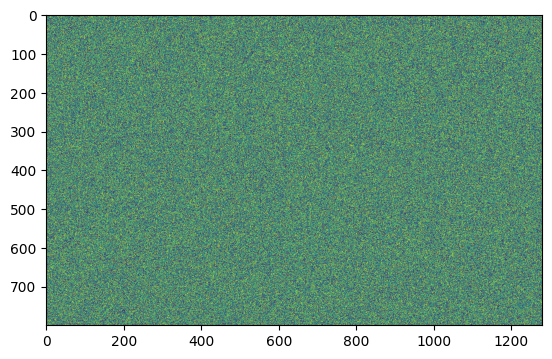

In [3]:
plt.imshow(np.angle(object))
plt.show()

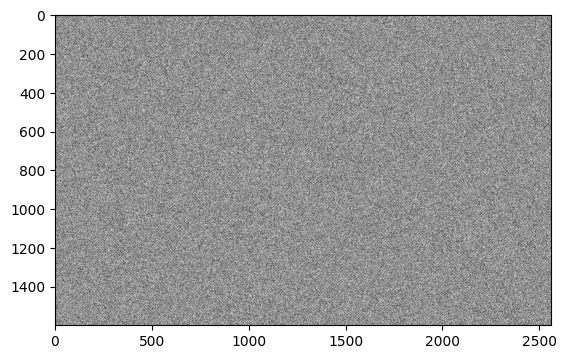

In [4]:
quant = PLMQuantizerGenerateMask(object)

plt.imshow(quant)
plt.show()

In [5]:
def bit_plane_to_str(bit_index: int) -> str:
    if not (0 <= bit_index <= 31):
        raise ValueError("bit_index must be between 0 and 31 inclusive")

    # ARGB: A=3, R=2, G=1, B=0
    channels = ['B', 'G', 'R', 'A']
    byte = bit_index // 8
    bit = bit_index % 8
    return f"{channels[byte]}{bit}"

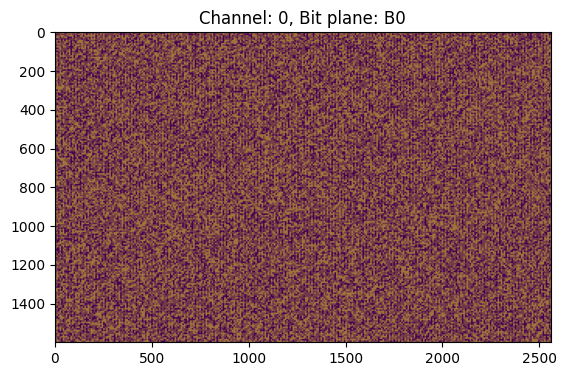

In [6]:
# Load from tmp
i=1
filename=f'../texture.png'
image=cv2.imread(filename,cv2.IMREAD_UNCHANGED)

H, W,C  = image.shape
# Split channels (OpenCV loads in BGRA order)
B, G, R, A = cv2.split(image)

# Convert to int32 using standard 0xAARRGGBB encoding
packed = (
    (A.astype(np.uint32) << 24) |
    (R.astype(np.uint32) << 16) |
    (G.astype(np.uint32) << 8)  |
    (B.astype(np.uint32))
).astype(np.int32)
s=[]
for channel in range(32):
    ch = (packed & (1 << channel)) >> channel
    if (np.sum(ch) != 0):
        break
plt.imshow(ch)
plt.title(f"Channel: {channel}, Bit plane: {bit_plane_to_str(channel)}")
plt.show()


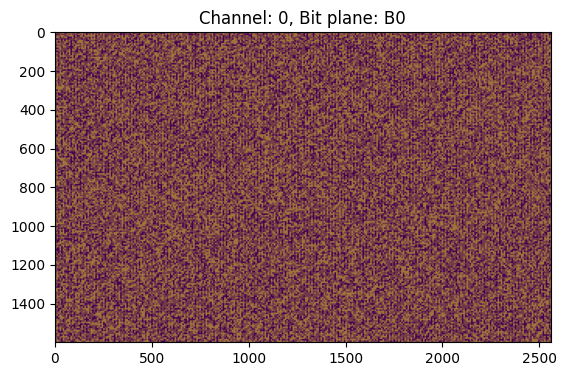

True

In [ ]:
# Load from tmp
i=1
filename=f'../texture.png'
image=cv2.imread(filename,cv2.IMREAD_UNCHANGED)

H, W,C  = image.shape
# Split channels (OpenCV loads in BGRA order)
B, G, R, A = cv2.split(image)

# Convert to int32 using standard 0xAARRGGBB encoding
packed = (
    (A.astype(np.uint32) << 24) |
    (R.astype(np.uint32) << 16) |
    (G.astype(np.uint32) << 8)  |
    (B.astype(np.uint32))
).astype(np.int32)
s=[]
channel = 0
ch = ((packed & (1 << channel)) >> channel).astype(np.uint8)
plt.imshow(ch)
plt.title(f"Channel: {channel}, Bit plane: {bit_plane_to_str(channel)}")
plt.show()

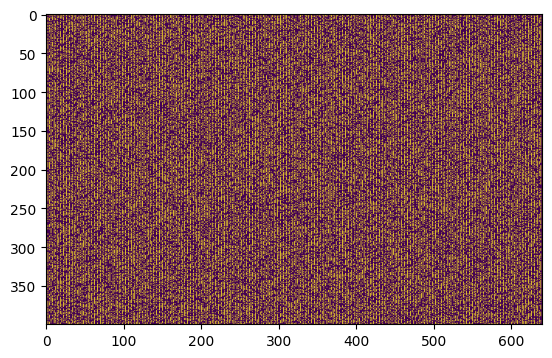

True

In [20]:

# Example input: binary image
# ch = np.random.randint(0, 2, (1600, 2560), dtype=np.uint8)

# Step 1: reshape to blocks
blocks = ch.reshape(800, 2, 1280, 2)  # shape (800, 2, 1280, 2)

# Step 2: take every 4th block
sampled_blocks = blocks[::4, :, ::4, :]  # shape (200, 2, 320, 2)

# Step 3: reduce each 2x2 block to scalar (sum or mean)
# Since it's binary, sum will give 0–4
#reduced = sampled_blocks.sum(axis=(1, 3))  # shape (200, 320)

# Step 4: reshape to (1600/4, 2560/4) == (400, 640)
final_result = sampled_blocks.reshape(400, 640)

plt.imshow(final_result)
plt.show()
cv2.imwrite("reduced.bmp", final_result*255)